In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline



gsv = pd.read_csv('./data/summary_census_sep_30_2020.csv')  # Google streetview Data
pedf = pd.read_csv('./data/EPA_walk.csv')

california = gpd.read_file('./data/california tracts.zip')
alabama = gpd.read_file('./data/alabama tracts.zip')

In [26]:
pedf['GEOID20'] = pedf['GEOID20'].astype('str')
pedf['GEOID20'] = [i[:-3] for i in pedf.GEOID20]
pedf['GEOID20'] = pedf['GEOID20'].astype('int64')
pedf = pd.DataFrame(pedf.groupby('GEOID20')['D3APO'].mean().reset_index())

In [27]:
def createCensus(state):
    state['GEOID'] = state['GEOID'].astype('int64')
    state = state.merge(pedf, left_on='GEOID', right_on='GEOID20', how='inner')
    state = state.merge(gsv, left_on='GEOID', right_on='GEOID', how='inner')
    state = state[['GEOID', 'geometry', 'D3APO', 'prop_crosswalk', 'prop_sidewalk' ]]
    state['lon'] = state['geometry'].centroid.x
    state['lat'] = state['geometry'].centroid.y
    
    return state

In [28]:
california = createCensus(california)

In [29]:
alabama = createCensus(alabama)

In [30]:
g_y = california['D3APO'].values.reshape((-1,1))
g_X = california[['prop_sidewalk']].values

u = california['lon']
v = california['lat']

g_coords = list(zip(u,v))

In [31]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X)
gwr_bw_o = gwr_selector_o.search()
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, 150, constant=True, lwcc=False).fit() # Use a fixed bandwidth of 150
gwr_results_o.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                8026
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4073.784
Log-likelihood:                                                   -8667.129
AIC:                                                              17338.259
AICc:                                                             17340.262
BIC:                                                             -68065.519
R2:                                                                   0.492
Adj. R2:                                                              0.492

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

In [32]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, 150)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
corr_mat.mean(), corr_mat.min(), corr_mat.max()

(0.4946384541147834, -0.2575748881196434, 0.9393845124342275)

In [33]:
california['gwr_calc'] = corr_mat

In [34]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X)
gwr_bw_n = gwr_selector_n.search()
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, 150, constant=False, lwcc=True).fit()
gwr_results_n.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                8026
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         224595.605
Log-likelihood:                                                  -24758.172
AIC:                                                              49518.345
AICc:                                                             49520.346
BIC:                                                             152447.312
R2:                                                                   0.487
Adj. R2:                                                              0.487

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

In [35]:
california['new_algo_params'] = gwr_results_n.params

In [36]:
import numpy as np 

def shift_colormap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    Parameters
    ----------
    cmap : The matplotlib colormap to be altered
    start : Offset from lowest point in the colormap's range.
      Defaults to 0.0 (no lower ofset). Should be between
      0.0 and `midpoint`.
    midpoint : The new center of the colormap. Defaults to
      0.5 (no shift). Should be between 0.0 and 1.0. In
      general, this should be  1 - vmax/(vmax + abs(vmin))
      For example if your data range from -15.0 to +5.0 and
      you want the center of the colormap at 0.0, `midpoint`
      should be set to  1 - 5/(5 + 15)) or 0.75
    stop : Offset from highets point in the colormap's range.
      Defaults to 1.0 (no upper ofset). Should be between
      `midpoint` and 1.0.
    
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    new_cmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=new_cmap)

    return new_cmap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    Function to truncate a colormap by selecting a subset of the original colormap's values
    Parameters
    ----------
    cmap : Mmatplotlib colormap to be altered
    minval : Minimum value of the original colormap to include in the truncated colormap
    maxval : Maximum value of the original colormap to include in the truncated colormap
    n : Number of intervals between the min and max values for the gradient of the truncated colormap
          
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl

    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def compare_surfaces(data, var1, var2, savefig=None):
    '''
    Function that creates comparative visualization of GWR and MGWR surfaces.
    Parameters
    ----------
    data   : pandas or geopandas Dataframe
             gwr/mgwr results
    var1   : string
             name of gwr parameter estimate column in frame
    var2   : string
             name of mgwr parameter estimate column in frame
    gwr_t  : string
             name of gwr t-values column in frame associated with var1
    gwr_bw : float
             bandwidth for gwr model for var1
    mgwr_t : string
             name of mgwr t-values column in frame associated with var2
    mgwr_bw: float
             bandwidth for mgwr model for var2
    name   : string
             common variable name to use for title
    kwargs1:
             additional plotting arguments for gwr surface
    kwargs2:
             additional plotting arguments for mgwr surface
    savefig: string, optional
             path to save the figure. Default is None. Not to save figure.
    '''
    import matplotlib.pyplot as plt
    import geopandas as gp
    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45, 38))
    ax0 = axes[0]
    ax0.set_title('Improved GW CC', fontsize=40)
    ax1 = axes[1]
    ax1.set_title('Classic GW CC', fontsize=40)

    #Set color map
    cmap = plt.cm.seismic

    #Find min and max values of the two combined datasets
    improved_min = data[var1].min()
    improved_max = data[var1].max()
    classic_min = data[var2].min()
    classic_max = data[var2].max()
    vmin = np.min([improved_min, classic_min])
    vmax = np.max([improved_max, classic_max])
    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0,
                              midpoint=1 - vmax / (vmax + abs(vmin)), stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
        vmin=vmin, vmax=vmax))

    #Plot GWR parameters
    data.plot(var1, cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax)


    #Plot MGWR parameters
    data.plot(var2, cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax)


    #Set figure options and plot
#     fig.tight_layout()
    fig.subplots_adjust(right=0.9)
    cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=50)
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

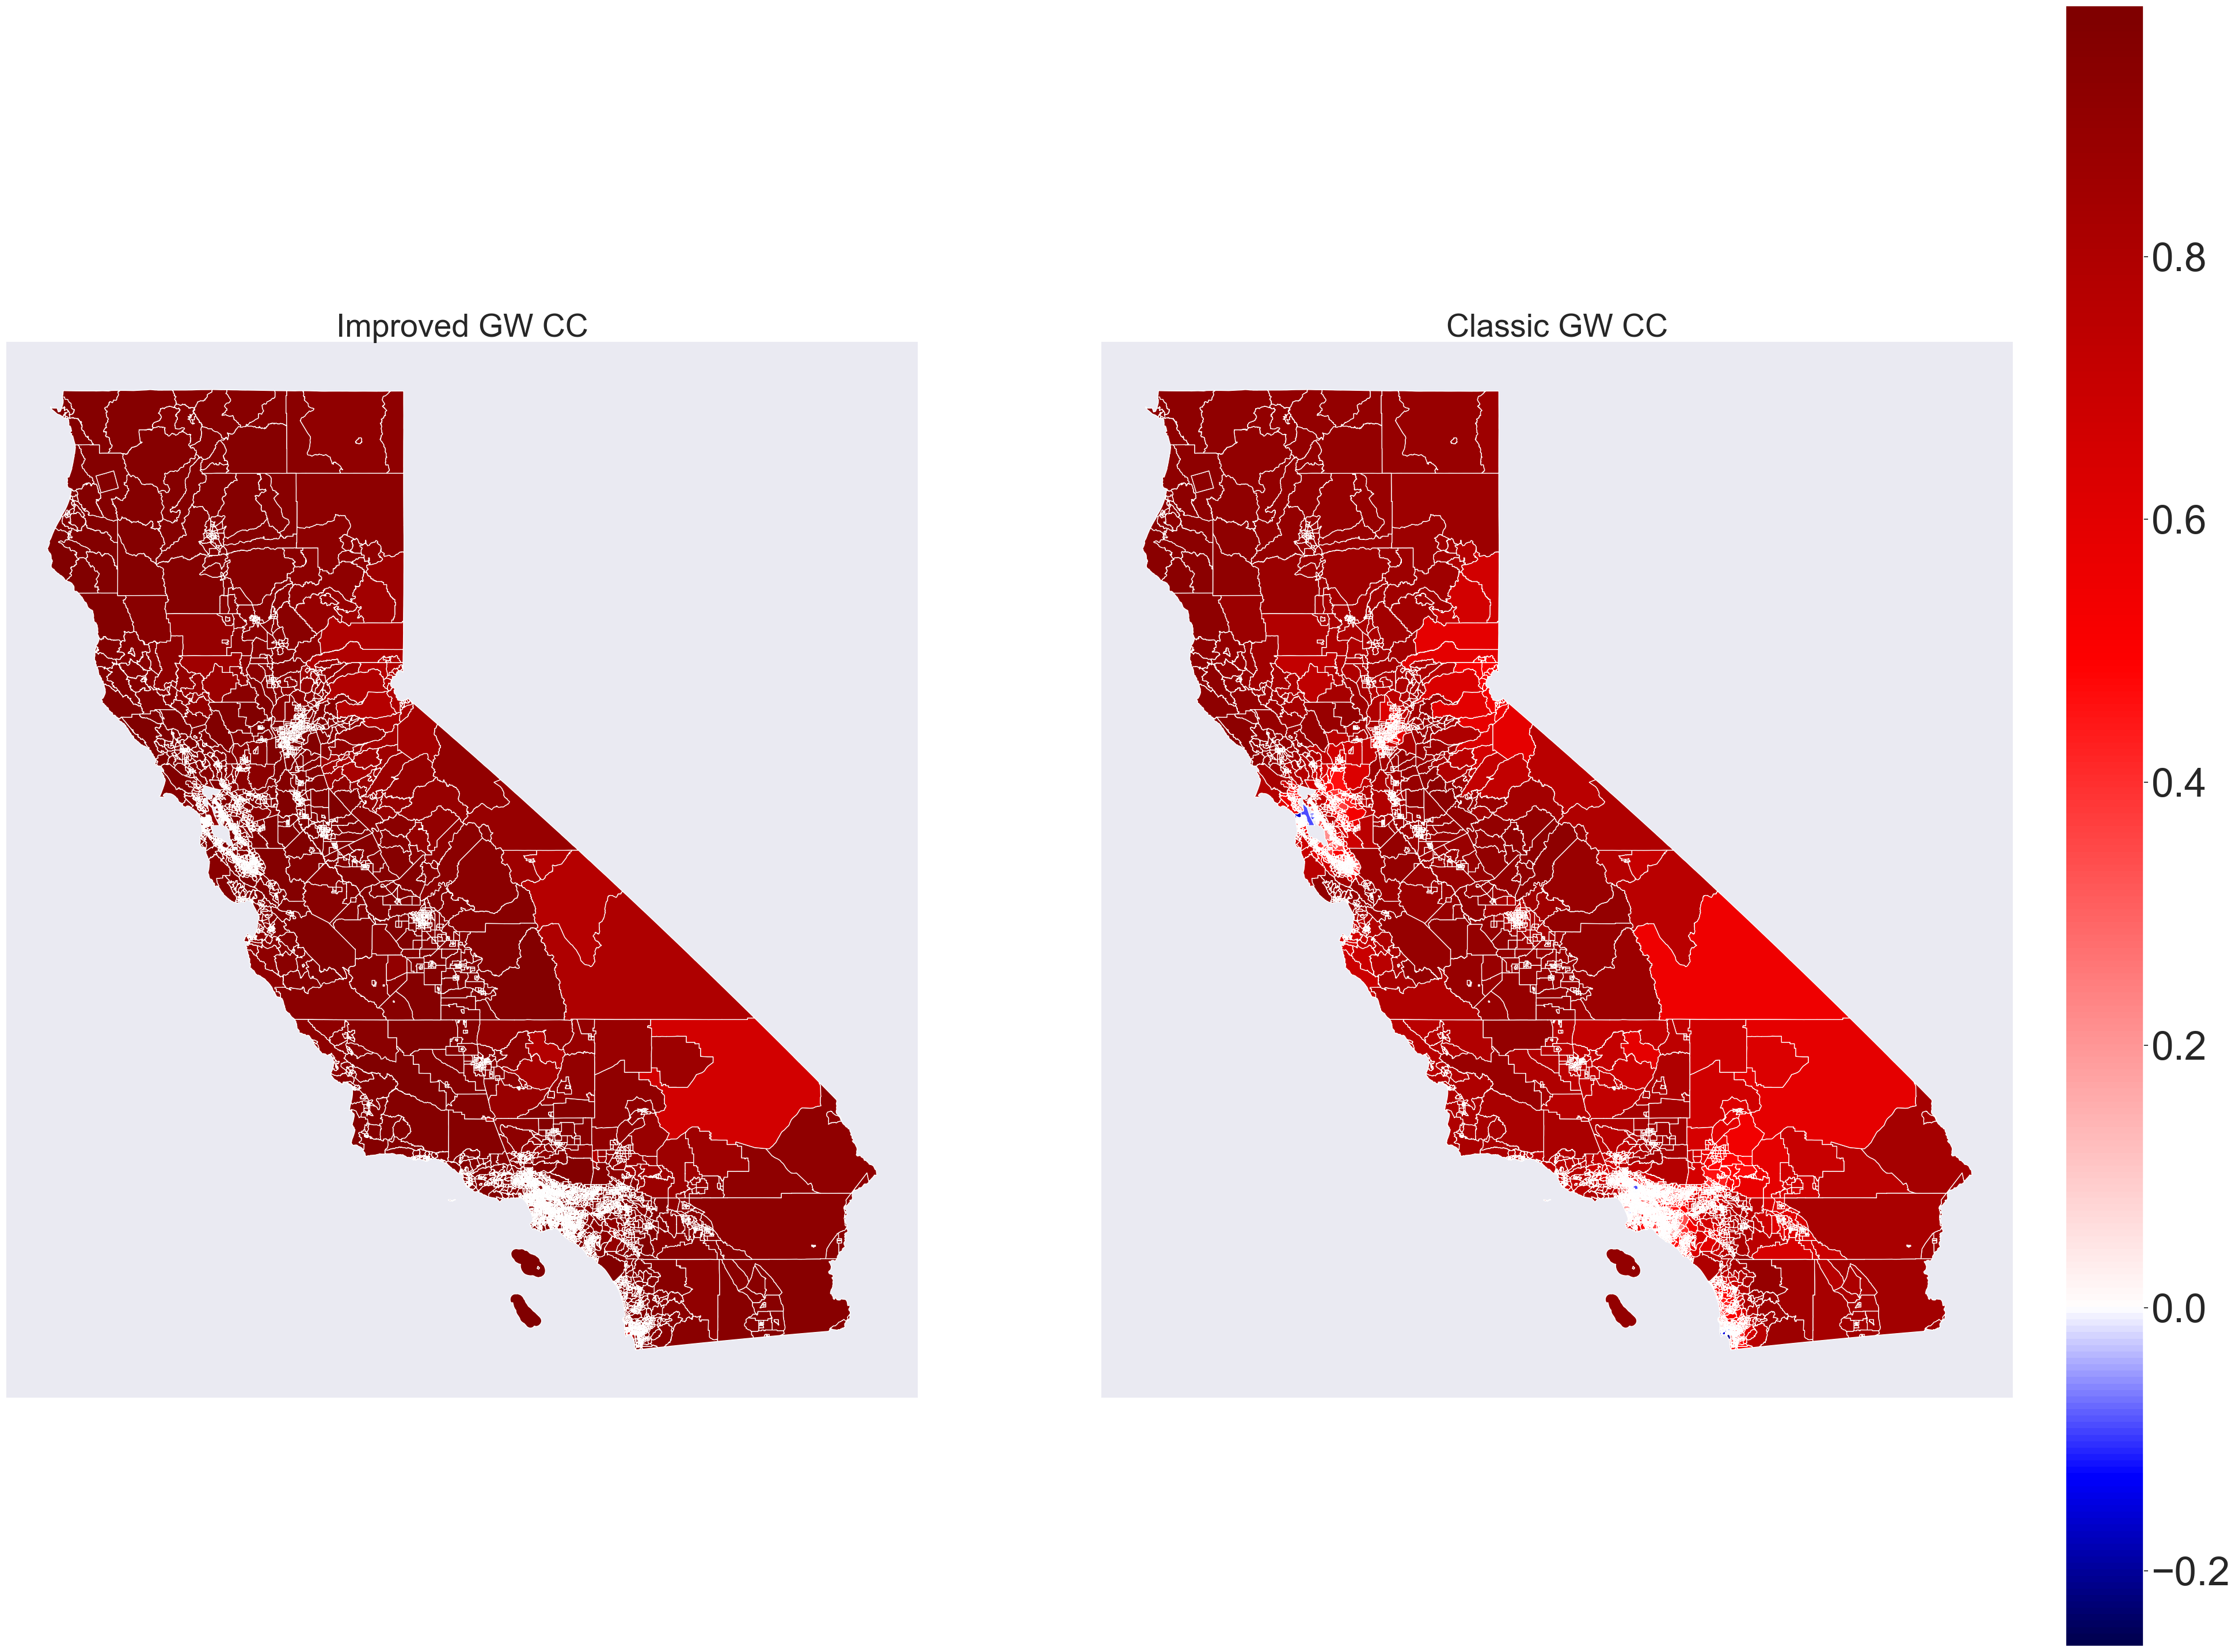

In [37]:
# from utils import compare_surfaces

compare_surfaces(california, 'new_algo_params', 'gwr_calc', savefig='./figs/fixed-bandwidth/use-case 2/cali-tracts.png')